In [1]:
#from get_albedo import *

import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline


Bad key "axes.spines.right" on line 223 in
/home/nicola/python/eoldas/two_stream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.spines.top" on line 224 in
/home/nicola/python/eoldas/two_stream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.prop_cycle" on line 214 in
/home/nicola/python/eoldas/two_stream/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution


In [2]:
fieldname = "Northampton_LowerFarm"
yearrange = [2006,2015]

In [3]:
#from eoldas_machinery import regularised_tip_inversion, tip_inversion
from Northampton_helpers import tip_inversion, regularised_tip_inversion

def regularised_inversion ( fluxnet_site, startdate, enddate, green_leaves, gamma_lai,
                                       n_tries=5, albedo_unc=[0.05, 0.07] ):

    #This function is a modified version of the one found in da_functions
    retval_s, state, obs, dates = tip_inversion( startdate, enddate, fluxnet_site, green_leaves=green_leaves,
                                          n_tries=n_tries )
    mu = state.operators['Prior'].mu
    cinv = state.operators['Prior'].inv_cov
    c = np.array(np.sqrt(np.linalg.inv (cinv.todense()).diagonal())).squeeze()
    post_sd = np.sqrt(np.array(retval_s['post_cov'].todense()).squeeze())
    post_sd_single = np.where(post_sd > c, c, post_sd)

    
    retval, state, obs, dates = regularised_tip_inversion( startdate, enddate, fluxnet_site, [1e-3, 0, 0.1, 1e-3, 0, 0.1, gamma_lai  ],
                                                    x0=retval_s['real_map'], green_leaves=green_leaves,
                                                    n_tries=n_tries, albedo_unc=albedo_unc )
    mu = state.operators['Prior'].mu
    cinv = state.operators['Prior'].inv_cov
    c = np.array(np.sqrt(np.linalg.inv (cinv.todense()).diagonal())).squeeze()
    post_sd = np.sqrt(np.array(retval['post_cov'].todense()).squeeze())
    post_sd = np.where(post_sd > c, c, post_sd)
    return retval, state, obs, mu, post_sd, dates

In [4]:
import datetime as dt
import numpy as np
from Northampton_helpers import retrieve_albedo_season
#startdate = dt.date(2006, 9, 1)
startdate = dt.date(2007, 1, 1)
#enddate= dt.date(2007, 9, 30)
enddate= dt.date(2007, 12, 31)

observations, mask, bu, passer_snow, dates = retrieve_albedo_season( startdate, enddate, 'Northampton_LowerFarm', [0.05, 0.07])
print dates
print [(d-startdate).days+1 for d in dates]
print mask

# The state grid should have numbers that match with the mask dates but that also fills the gaps
# mask contains doy

startdoy = startdate


[datetime.date(2007, 1, 9) datetime.date(2007, 1, 17)
 datetime.date(2007, 1, 25) datetime.date(2007, 2, 2)
 datetime.date(2007, 2, 18) datetime.date(2007, 2, 26)
 datetime.date(2007, 3, 6) datetime.date(2007, 3, 14)
 datetime.date(2007, 3, 22) datetime.date(2007, 3, 30)
 datetime.date(2007, 4, 7) datetime.date(2007, 4, 15)
 datetime.date(2007, 4, 23) datetime.date(2007, 5, 1)
 datetime.date(2007, 5, 9) datetime.date(2007, 5, 17)
 datetime.date(2007, 5, 25) datetime.date(2007, 6, 2)
 datetime.date(2007, 6, 26) datetime.date(2007, 7, 4)
 datetime.date(2007, 7, 12) datetime.date(2007, 7, 20)
 datetime.date(2007, 7, 28) datetime.date(2007, 8, 5)
 datetime.date(2007, 8, 13) datetime.date(2007, 8, 21)
 datetime.date(2007, 8, 29) datetime.date(2007, 9, 6)
 datetime.date(2007, 9, 14) datetime.date(2007, 9, 22)
 datetime.date(2007, 9, 30) datetime.date(2007, 10, 8)
 datetime.date(2007, 10, 16) datetime.date(2007, 10, 24)
 datetime.date(2007, 11, 1) datetime.date(2007, 11, 9)
 datetime.date(200

In [7]:
startdate = dt.date(2007, 1, 1)
enddate= dt.date(2007, 12, 31)
retval, state, obs, mu, post_sd, dates = regularised_inversion(
        "Northampton_LowerFarm", startdate, enddate, green_leaves=False, gamma_lai=1, n_tries=1)

[  1   9  17  25  33  41  49  57  65  73  81  89  97 105 113 121 129 137
 145 153 161 169 177 185 193 201 209 217 225 233 241 249 257 265 273 281
 289 297 305 313 321 329 337 345 353 361]
2007-12-31 2007-01-01
[  1   9  17  25  33  41  49  57  65  73  81  89  97 105 113 121 129 137
 145 153 161 169 177 185 193 201 209 217 225 233 241 249 257 265 273 281
 289 297 305 313 321 329 337 345 353 361]
46
Saving results to eoldas_retval_20170103_173627_SH97R
('x_dict = ', {'a_nir': array([ 0.18      ,  0.18429497,  0.18028945,  0.19989429,  0.20649494,
        0.18      ,  0.20397936,  0.21869153,  0.22651678,  0.22585107,
        0.22512409,  0.24198363,  0.242798  ,  0.24443922,  0.25261503,
        0.2428168 ,  0.22900259,  0.24497225,  0.22373913,  0.21383035,
        0.18      ,  0.18      ,  0.21652906,  0.21906976,  0.25416147,
        0.30582927,  0.28002314,  0.21549865,  0.22206312,  0.22206312,
        0.30684042,  0.28536099,  0.2881154 ,  0.2066861 ,  0.21110969,
        0.2164032

ValueError: operands could not be broadcast together with shapes (322,) (294,) 

In [ ]:
%debug

> /home/nicola/python/eoldas/two_stream/build/bdist.linux-x86_64/egg/eoldas_ng/operators.py(234)der_cost()

ipdb> print self.mu
[ 0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17
  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17
  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17
  0.17  0.17  0.17  0.17  0.17  0.17  1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    0.1   0.1   0.1
  0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1
  0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1
  0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1
  0.1   0.1   0.1   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7
  0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   0.7   

In [10]:
retvals = []
states = []
post_sds = []
dates = []
for year in xrange(*yearrange):
    print year
    startdate = dt.date(year-1, 9, 1)
    
    enddate= dt.date(year, 9, 30)
    
    startdate = dt.date(year, 1, 1)
    enddate= dt.date(year, 12, 31)

    retval, state, obs, mu, post_sd, date = regularised_inversion(
        "Northampton_LowerFarm", startdate, enddate, green_leaves=False, gamma_lai=1, n_tries=2)
    retvals.append(retval)
    states.append(state)
    post_sds.append(post_sd)
    dates.append(date)
    

2006
Saving results to eoldas_retval_20170103_113633_SH97R


ValueError: total size of new array must be unchanged

In [9]:
debug


> /home/nicola/python/eoldas/two_stream/build/bdist.linux-x86_64/egg/eoldas_ng/state.py(370)_unpack_to_dict()

ipdb> print x[i:(i+self.n_elems_masked)]
[ -1.66839997   0.96805245   4.00878379   1.11127618  12.40727871
   6.26821284   6.13538664   3.3578225    1.7248779    1.23149688
   7.44749666   1.06784419   6.23117566  -3.98635705 -10.1550641
   2.43875406  -4.28648177   1.10507207  -1.78877984  -1.71345032
   8.72147351  -1.57621642   0.52953006   6.39275868   0.0163284
   8.1013222    3.95057198   5.27962063   1.98656713  -0.74547953
   2.40291285   8.46109726  13.34145483]
ipdb> print i
240

KeyboardInterrupt


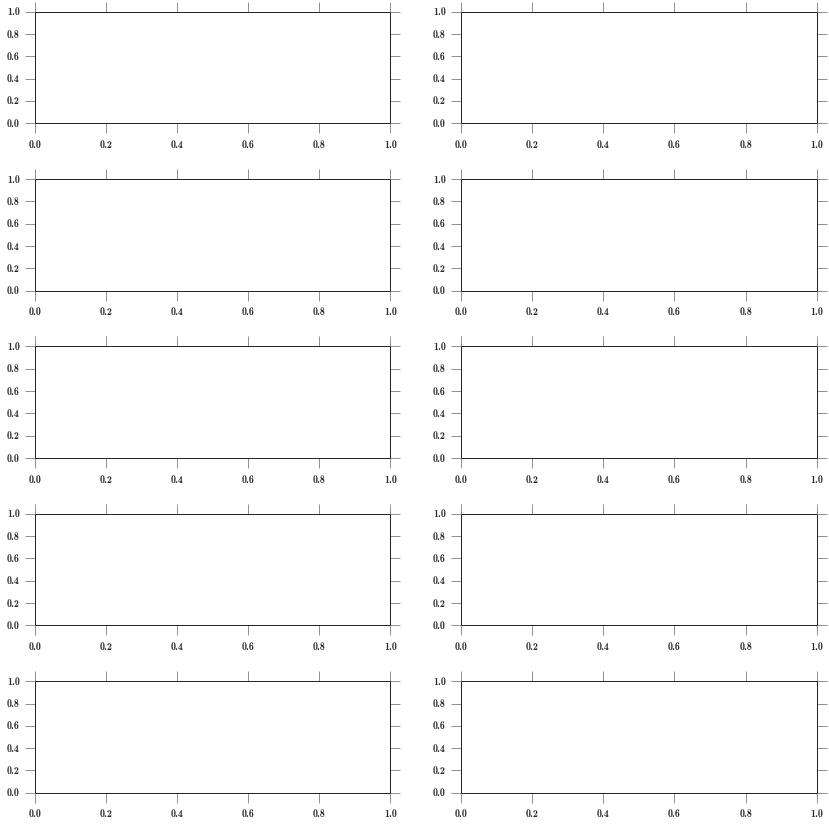

In [21]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,14))
axs = axs.flatten()
for state, retval, post_sd, ax, year in zip(states, retvals, post_sds, axs, xrange(*yearrange)):
    lenstate = len(state.state_grid)
    print lenstate
    param = 6
    ax.fill_between ( state.state_grid, retval['real_map']['lai'] - 
                     post_sd[(param*lenstate):((param+1)*lenstate)],
                     retval['real_map']['lai'] + post_sd[(param*lenstate):((param+1)*lenstate)], 
                     lw=0.8, color="0.8")
    ax.plot(state.state_grid, retval['real_map']['lai'], 'o-', mfc="none")
    ax.set_ylim([-2, 4])
    ax.set_title(year)

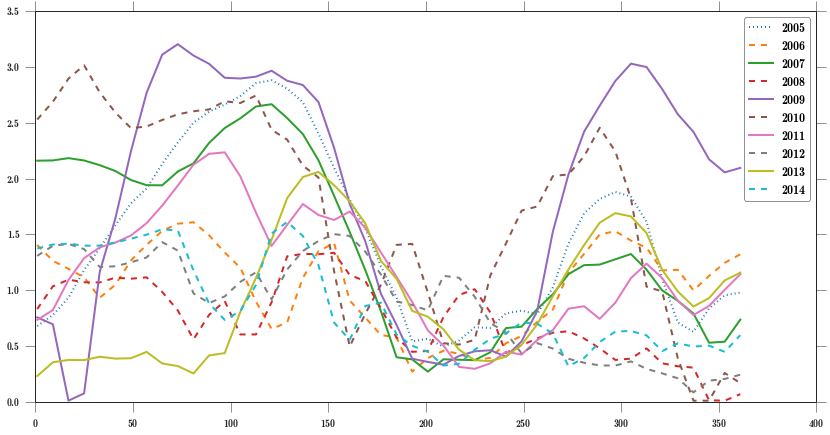

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
line_style = [':', '--', '-', '--', '-', '--', '-', '--', '-', '--', '-', '--', '-']

for state, retval, c, l in zip(states, retvals, new_colors, line_style):
    
    #i = 6
    #ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
    #                        retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    ax.plot(state.state_grid, retval['real_map']['lai'], l, mfc="none", color=c)
ax.legend (range(*yearrange))

In [1]:


import cPickle as pickle 

data = pickle.load(open('eoldas_retval_20161201_131221_SH97R.pkl'))

In [21]:
print data['real_map'].keys()
data['hessian'].todense()


['omega_vis', 'd_vis', 'a_vis', 'omega_nir', 'd_nir', 'a_nir', 'lai']


matrix([[  1.00533964e+04,  -1.00000000e-03,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.00000000e-03,   3.17566131e+03,  -1.00000000e-03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,  -1.00000000e-03,   3.40352497e+03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           1.52124026e+02,  -1.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          -1.00000000e+00,   9.14282312e+01,  -1.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,  -1.00000000e+00,   1.04000000e+00]])

In [21]:
print mask


[[  1   1]
 [  9   1]
 [ 17   1]
 [ 25   1]
 [ 33   1]
 [ 41   1]
 [ 49   1]
 [ 57   1]
 [ 65   1]
 [ 73   1]
 [ 81   1]
 [ 89   1]
 [ 97   1]
 [105   1]
 [113   1]
 [121   1]
 [129   1]
 [137   1]
 [145   1]
 [153   1]
 [161   1]
 [169   1]
 [177   1]
 [185   1]
 [193   1]
 [201   1]
 [209   1]
 [217   1]
 [225   1]
 [241   1]
 [249   1]
 [273   1]
 [281   1]
 [289   1]
 [297   1]
 [305   1]
 [313   1]
 [329   1]
 [337   1]
 [345   1]
 [353   1]
 [361   1]]
